### Data

In [1]:
#Imports
import xarray as xr
import sys
sys.path.append('/home/563/rl5183/Functions')
import model_functions as func
import os
import pandas as pd
import numpy as np
import scipy
from scipy import signal
import iris
import iris.analysis.stats as istats
from importlib import reload
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
func=reload(func)

In [3]:
#Historical model runs
hist_temp = func.read_hist_models('/g/data/lp01/CMIP6/CMIP/', '/historical/r1i1p1f1/Amon/ts/gr1.5/')
hist_precip = func.read_hist_models('/g/data/lp01/CMIP6/CMIP/', '/historical/r1i1p1f1/Amon/pr/gr1.5/')

GISS-E2-2-G path does not exist
MIROC-ES2L path does not exist
FIO-ESM-2-0 path does not exist
HadGEM3-GC31-MM path does not exist
HadGEM3-GC31-LL path does not exist
UKESM1-0-LL path does not exist
CNRM-ESM2-1 path does not exist
CNRM-CM6-1 path does not exist
EC-Earth3-LR path does not exist
NorESM1-F path does not exist
IITM-ESM path does not exist
44 model paths found and stored in models dictionary
MPI-ESM-1-2-HAM /g/data/lp01/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ESM-1-2-HAM/historical/r1i1p1f1/Amon/ts/gr1.5/v20190627/*.nc
NESM3 /g/data/lp01/CMIP6/CMIP/NUIST/NESM3/historical/r1i1p1f1/Amon/ts/gr1.5/v20190630/*.nc
MCM-UA-1-0 /g/data/lp01/CMIP6/CMIP/UA/MCM-UA-1-0/historical/r1i1p1f1/Amon/ts/gr1.5/v20190731/*.nc
ACCESS-CM2 /g/data/lp01/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/Amon/ts/gr1.5/v20190919/*.nc
MPI-ESM1-2-HR /g/data/lp01/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/Amon/ts/gr1.5/v20190710/*.nc
MPI-ESM1-2-LR /g/data/lp01/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/historic

In [4]:
#Future model runs
future_temp = func.read_future_models('/g/data/lp01/CMIP6/ScenarioMIP/', '/ssp585/r1i1p1f1/Amon/ts/gr1.5/')
future_precip = func.read_future_models('/g/data/lp01/CMIP6/ScenarioMIP/', '/ssp585/r1i1p1f1/Amon/pr/gr1.5/')

MPI-ESM-1-2-HAM path does not exist
MCM-UA-1-0 path does not exist
MIROC-ES2L path does not exist
FIO-ESM-2-0 path does not exist
UKESM1-0-LL path does not exist
CNRM-ESM2-1 path does not exist
CNRM-CM6-1 path does not exist
27 model paths found and stored in models dictionary
NESM3 /g/data/lp01/CMIP6/ScenarioMIP/NUIST/NESM3/ssp585/r1i1p1f1/Amon/ts/gr1.5/v20190728/*.nc
ACCESS-CM2 /g/data/lp01/CMIP6/ScenarioMIP/CSIRO-ARCCSS/ACCESS-CM2/ssp585/r1i1p1f1/Amon/ts/gr1.5/v20190924/*.nc
MPI-ESM1-2-LR /g/data/lp01/CMIP6/ScenarioMIP/MPI-M/MPI-ESM1-2-LR/ssp585/r1i1p1f1/Amon/ts/gr1.5/v20190710/*.nc
IPSL-CM6A-LR /g/data/lp01/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR/ssp585/r1i1p1f1/Amon/ts/gr1.5/v20190119/*.nc
FGOALS-f3-L /g/data/lp01/CMIP6/ScenarioMIP/CAS/FGOALS-f3-L/ssp585/r1i1p1f1/Amon/ts/gr1.5/v20191013/*.nc
FGOALS-g3 /g/data/lp01/CMIP6/ScenarioMIP/CAS/FGOALS-g3/ssp585/r1i1p1f1/Amon/ts/gr1.5/v20190818/*.nc
BCC-CSM2-MR /g/data/lp01/CMIP6/ScenarioMIP/BCC/BCC-CSM2-MR/ssp585/r1i1p1f1/Amon/ts/gr1.5/v201903

In [5]:
#Find common models between all four datasets
hist_temp = hist_temp.where(hist_temp.model.isin(hist_precip.model), drop = True)
hist_temp = hist_temp.where(hist_temp.model.isin(future_temp.model), drop = True)
hist_temp = hist_temp.where(hist_temp.model.isin(future_precip.model), drop = True)
hist_precip = hist_precip.where(hist_precip.model.isin(hist_temp.model), drop = True)
future_temp = future_temp.where(future_temp.model.isin(hist_temp.model), drop = True)
future_precip = future_precip.where(future_precip.model.isin(hist_temp.model), drop = True)

In [6]:
#discard models rejected by model evaluation
future_ts = future_temp.ts.drop_sel(model=['INM-CM4-8', 'INM-CM5-0'])
hist_ts = hist_temp.ts.drop_sel(model=['INM-CM4-8', 'INM-CM5-0'])
future_pr = future_precip.pr.drop_sel(model=['INM-CM4-8', 'INM-CM5-0'])
hist_pr = hist_precip.pr.drop_sel(model=['INM-CM4-8', 'INM-CM5-0'])

### Mean State

In [7]:
#landmask
landmask_ds = xr.open_dataset('/g/data/eg3/pfd548/gridarea/land-sea_mask/fractional_land.1.5-deg.nc')
landmask = landmask_ds.mean(dim='time')

In [24]:
future_clim = future_ts.sel(time=slice('2070-01', '2099-12'))
future_clim = future_clim - 273.15 #convert from k to c
hist_clim = hist_ts.sel(time=slice('1970-01', '1999-12'))
hist_clim = hist_clim - 273.15 #convert from k to c

In [9]:
hist_pr = hist_pr*86400
future_pr = future_pr*86400

Text(0.5, 1.0, 'f) Precipitation Difference')

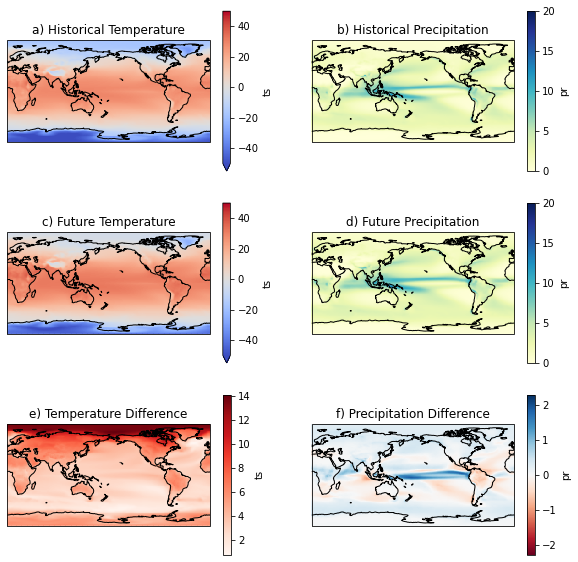

In [60]:
#Plot obs and multimodel mean 

#historical temperature (1970-1999)
hist_temp_mmm = hist_clim.mean(dim=['model', 'time'])

#future temperature (2070-2099)
future_temp_mmm = future_clim.mean(dim=['model', 'time'])

#historical precip (1970-1999)
hist_pr_mmm = hist_pr.mean(dim=['model', 'time'])

#future precip (2070-2099)
future_pr_mmm = future_pr.mean(dim=['model', 'time'])

#calculate difference
temp_diff = future_temp_mmm - hist_temp_mmm
precip_diff = future_pr_mmm - hist_pr_mmm

fig = plt.figure(figsize=(10,10))


ax = fig.add_subplot(321, projection=ccrs.PlateCarree(180))
C = hist_temp_mmm.plot(ax=ax, vmin=-50, vmax=50, transform=ccrs.PlateCarree(), cmap='coolwarm')
ax.coastlines()
ax.set_title('a) Historical Temperature')

ax = fig.add_subplot(322, projection=ccrs.PlateCarree(180))
C = hist_pr_mmm.plot(ax=ax, vmin=0, vmax=20, transform=ccrs.PlateCarree(), cmap='YlGnBu')
ax.coastlines()
ax.set_title('b) Historical Precipitation')

ax = fig.add_subplot(323, projection=ccrs.PlateCarree(180))
C = future_temp_mmm.plot(ax=ax, vmin=-50, vmax=50, transform=ccrs.PlateCarree(), cmap='coolwarm')
ax.coastlines()
ax.set_title('c) Future Temperature')

ax = fig.add_subplot(324, projection=ccrs.PlateCarree(180))
C = future_pr_mmm.plot(ax=ax, vmin=0, vmax=20, transform=ccrs.PlateCarree(), cmap='YlGnBu')
ax.coastlines()
ax.set_title('d) Future Precipitation')

ax = fig.add_subplot(325, projection=ccrs.PlateCarree(180))
C = temp_diff.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Reds')
ax.coastlines()
ax.set_title('e) Temperature Difference')

ax = fig.add_subplot(326, projection=ccrs.PlateCarree(180))
C = precip_diff.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu')
ax.coastlines()
ax.set_title('f) Precipitation Difference')

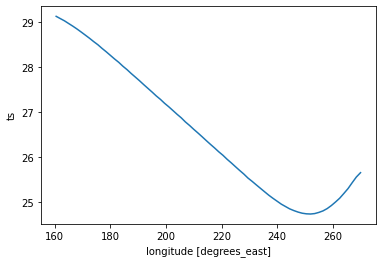

In [67]:
zon_grad_hist = hist_temp_mmm.sel(lat=slice(-5,4)).sel(lon=slice(160, 270)).mean(dim='lat')
zon_grad_hist.plot()

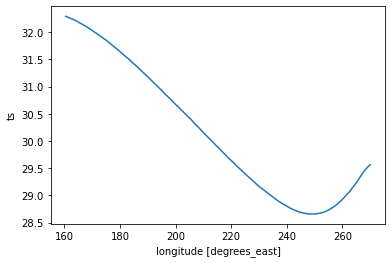

In [68]:
zon_grad_future = future_temp_mmm.sel(lat=slice(-5,4)).sel(lon=slice(160, 270)).mean(dim='lat')
zon_grad_future.plot()

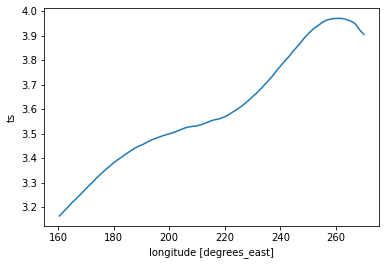

In [69]:
zon_grad_change = zon_grad_future - zon_grad_hist
zon_grad_change.plot()